# Objective
  In this question we use CIFAR 10 Dataset to perform different variations given in the question.
  The CIFAR-10 dataset is similar to MNIST, except that instead of one color channel (grayscale) there are three channels (RGB).
Where a CIFAR images are (3,32,32). There are 10 categories an image may fall under:


1.   airplane
2.   automobile
3.   bird
4.   cat
5.   deer
6.   dog
7.   frog
8.   horse
9.   ship
10.  truck

### Necessary Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchsummary import summary

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Data Exploration

#### CIFAR-10 train and test datasets available through torchvision.The set contains 50,000 train and 10,000 test images .

In [ ]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='Data', train=True, download=True, transform=transform)

test_data = datasets.CIFAR10(root='Data', train=False, download=True, transform=transform)


Extracting Data/cifar-10-python.tar.gz to Data
Files already downloaded and verified


In [ ]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: Data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Split into 70:30 after concated both

In [ ]:
model_data=train_data+test_data
total_count=len(model_data)
total_count

60000

In [ ]:
train_count = int(0.7 * total_count) 
test_count = int(0.3 * total_count)

In [ ]:
train_data, test_data = torch.utils.data.random_split(model_data, (train_count, test_count))
print(len(train_data))
print(len(test_data))
type(train_data)

42000
18000


torch.utils.data.dataset.Subset

In [ ]:
train_data[0]

(tensor([[[0.8471, 0.8510, 0.8510,  ..., 0.8667, 0.8784, 0.8863],
          [0.8549, 0.8588, 0.8588,  ..., 0.8667, 0.8784, 0.8824],
          [0.8627, 0.8667, 0.8667,  ..., 0.8667, 0.8784, 0.8745],
          ...,
          [0.5608, 0.5647, 0.5686,  ..., 0.5529, 0.5647, 0.5608],
          [0.4627, 0.4863, 0.4863,  ..., 0.4941, 0.5059, 0.5059],
          [0.4078, 0.4196, 0.4471,  ..., 0.4588, 0.4745, 0.4706]],
 
         [[0.8667, 0.8706, 0.8706,  ..., 0.8706, 0.8824, 0.8980],
          [0.8745, 0.8784, 0.8824,  ..., 0.8667, 0.8784, 0.8941],
          [0.8863, 0.8902, 0.8902,  ..., 0.8667, 0.8784, 0.8941],
          ...,
          [0.4510, 0.4510, 0.4549,  ..., 0.4078, 0.4118, 0.4118],
          [0.4078, 0.4314, 0.4314,  ..., 0.4314, 0.4353, 0.4392],
          [0.3686, 0.3804, 0.4000,  ..., 0.4314, 0.4471, 0.4471]],
 
         [[0.9843, 0.9882, 0.9882,  ..., 0.9843, 0.9961, 0.9961],
          [0.9882, 0.9922, 0.9922,  ..., 0.9961, 1.0000, 1.0000],
          [0.9922, 0.9961, 0.9961,  ...,

### Creating Loaders

In [ ]:
torch.manual_seed(101)  # for reproducible results

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)   ## here taking batch size as 10
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

### Viewing batch of images

In [ ]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

Label: [    5     7     2     0     6     5     7     3     3     5]
Class:    dog horse  bird plane  frog   dog horse   cat   cat   dog


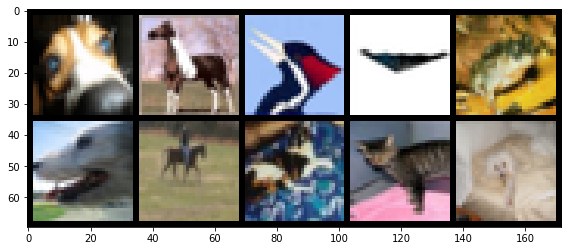

In [ ]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Supporting functions

In [ ]:
def train_model(train_loader,test_loader,model):
  import time
  start_time = time.time()

  epochs = 20
  train_losses = []
  test_losses = []
  train_correct = []
  test_correct = []

  for i in range(epochs):
      trn_corr = 0
      tst_corr = 0
      
      # Run the training batches
      for b, (X_train, y_train) in enumerate(train_loader):
          b+=1
          
          # Apply the model
          y_pred = model(X_train)
          loss = criterion(y_pred, y_train)
  
          # Tally the number of correct predictions
          predicted = torch.max(y_pred.data, 1)[1]
          batch_corr = (predicted == y_train).sum()
        
          trn_corr += batch_corr
          
          # Update parameters
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # Print interim results
          if b%1000 == 0:
              print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/42000]  loss: {loss.item():10.8f}  \
  accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
          
      train_losses.append(loss)
      train_correct.append(trn_corr)
      
          
      # Run the testing batches
      with torch.no_grad():
          for b, (X_test, y_test) in enumerate(test_loader):

              # Apply the model
              y_val = model(X_test)

              # Tally the number of correct predictions
              predicted = torch.max(y_val.data, 1)[1] 
              tst_corr += (predicted == y_test).sum()
              
      loss = criterion(y_val, y_test)
      test_losses.append(loss)
      test_correct.append(tst_corr)
          
  print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

  return train_losses,test_losses,train_correct,test_correct


In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
def plot_loss(train_losses,test_losses):
  plt.plot(train_losses, label='training loss')
  plt.plot(test_losses, label='validation loss')
  plt.title('Loss at the end of each epoch')
  plt.legend();

In [ ]:
def plot_accuracy(train_correct,test_correct):
  plt.plot([t/500 for t in train_correct], label='training accuracy')
  plt.plot([t/100 for t in test_correct], label='validation accuracy')
  plt.title('Accuracy at the end of each epoch')
  plt.legend();

In [ ]:
# Create a loader for the entire the test set
def confusionMatrix(test_data,model):
  test_load_all = DataLoader(test_data, batch_size=18000, shuffle=False)

  with torch.no_grad():
      correct = 0
      for X_test, y_test in test_load_all:
          y_val = model(X_test)
          predicted = torch.max(y_val,1)[1]
          correct += (predicted == y_test).sum()
  print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

  arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
  df_cm = pd.DataFrame(arr, class_names, class_names)
  plt.figure(figsize = (9,6))
  sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
  plt.xlabel("prediction")
  plt.ylabel("label (ground truth)")
  plt.show();

# Defining the models 


## Part 1)


In [ ]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, padding=0)
        self.batch_norm=nn.BatchNorm2d(10)
        self.fc1 = nn.Linear(10* 14 * 14, 10)

    def forward(self, X):
        X = F.relu(self.batch_norm(self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(X.size(0), -1)
        X = F.relu(self.fc1(X))
        
        return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(101)
model = CNN1()
model

CNN1(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1960, out_features=10, bias=True)
)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
count_parameters(model)

   750
    10
    10
    10
 19600
    10
______
 20390


### Define loss function & opt

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Training the Model

In [ ]:
train_losses,test_losses,train_correct,test_correct=train_model(train_loader,test_loader,model)

epoch:  0  batch: 1000 [ 10000/42000]  loss: 2.12567759    accuracy:  11.120%
epoch:  0  batch: 2000 [ 20000/42000]  loss: 2.44728470    accuracy:  11.380%
epoch:  0  batch: 3000 [ 30000/42000]  loss: 2.35558558    accuracy:  11.773%
epoch:  0  batch: 4000 [ 40000/42000]  loss: 2.34729934    accuracy:  12.102%
epoch:  1  batch: 1000 [ 10000/42000]  loss: 2.47487164    accuracy:  14.670%
epoch:  1  batch: 2000 [ 20000/42000]  loss: 2.24916315    accuracy:  15.665%
epoch:  1  batch: 3000 [ 30000/42000]  loss: 2.22196412    accuracy:  16.710%
epoch:  1  batch: 4000 [ 40000/42000]  loss: 2.04326272    accuracy:  17.212%
epoch:  2  batch: 1000 [ 10000/42000]  loss: 1.67343211    accuracy:  30.650%
epoch:  2  batch: 2000 [ 20000/42000]  loss: 2.32572794    accuracy:  33.480%
epoch:  2  batch: 3000 [ 30000/42000]  loss: 1.95437884    accuracy:  35.180%
epoch:  2  batch: 4000 [ 40000/42000]  loss: 1.32717299    accuracy:  36.383%
epoch:  3  batch: 1000 [ 10000/42000]  loss: 1.45290828    accur

### Plotting the loss and accuracy comparisions

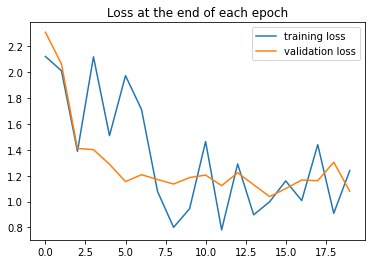

In [ ]:
plot_loss(train_losses,test_losses)


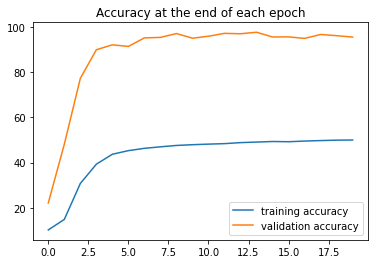

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/18000:.3f}%') # print the most recent result as a percent

[tensor(2212), tensor(4815), tensor(7734), tensor(9002), tensor(9219), tensor(9150), tensor(9527), tensor(9548), tensor(9719), tensor(9513), tensor(9601), tensor(9728), tensor(9710), tensor(9777), tensor(9566), tensor(9572), tensor(9504), tensor(9678), tensor(9625), tensor(9562)]

Test accuracy: 53.122%


## Part a)  No batch Normalisation


In [ ]:
class CNNa(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, padding=0)
        #self.batch_norm=nn.BatchNorm2d(10)
        self.fc1 = nn.Linear(10* 14 * 14, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(X.size(0), -1)
        X = self.fc1(X)
        
        return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(101)
modela = CNNa()
modela

CNNa(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1960, out_features=10, bias=True)
)

In [ ]:

def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
count_parameters(modela)

   750
    10
 19600
    10
______
 20370


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modela.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_losses,test_losses,train_correct,test_correct=train_model(train_loader,test_loader,modela)

epoch:  0  batch: 1000 [ 10000/42000]  loss: 1.77388096    accuracy:  26.430%
epoch:  0  batch: 2000 [ 20000/42000]  loss: 1.16975784    accuracy:  32.310%
epoch:  0  batch: 3000 [ 30000/42000]  loss: 1.66330779    accuracy:  35.823%
epoch:  0  batch: 4000 [ 40000/42000]  loss: 1.24023008    accuracy:  38.250%
epoch:  1  batch: 1000 [ 10000/42000]  loss: 1.74139309    accuracy:  48.170%
epoch:  1  batch: 2000 [ 20000/42000]  loss: 1.94654346    accuracy:  48.490%
epoch:  1  batch: 3000 [ 30000/42000]  loss: 1.31246865    accuracy:  48.890%
epoch:  1  batch: 4000 [ 40000/42000]  loss: 1.04638886    accuracy:  49.320%
epoch:  2  batch: 1000 [ 10000/42000]  loss: 0.88920051    accuracy:  51.060%
epoch:  2  batch: 2000 [ 20000/42000]  loss: 2.68181682    accuracy:  52.090%
epoch:  2  batch: 3000 [ 30000/42000]  loss: 0.81296778    accuracy:  51.733%
epoch:  2  batch: 4000 [ 40000/42000]  loss: 1.37580752    accuracy:  52.020%
epoch:  3  batch: 1000 [ 10000/42000]  loss: 1.59683204    accur

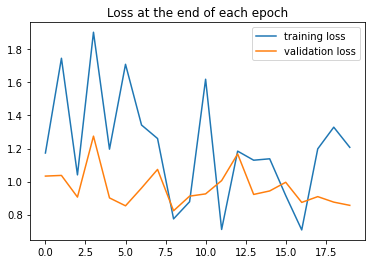

In [ ]:
plot_loss(train_losses,test_losses)

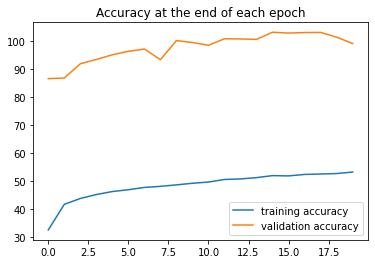

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/18000:.3f}%') # print the most recent result as a percent

[tensor(8650), tensor(8671), tensor(9181), tensor(9335), tensor(9502), tensor(9625), tensor(9707), tensor(9326), tensor(10009), tensor(9941), tensor(9844), tensor(10073), tensor(10068), tensor(10052), tensor(10307), tensor(10278), tensor(10296), tensor(10301), tensor(10131), tensor(9905)]

Test accuracy: 55.028%


## Part b)

In [ ]:
class CNNb(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, padding=0)
        self.batch_norm=nn.BatchNorm2d(10)
        self.fc1 = nn.Linear(10* 14 * 14, 64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, X):
        X = F.relu(self.batch_norm(self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(X.size(0), -1)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        
        return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(101)
modelb = CNNb()
modelb

CNNb(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1960, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
count_parameters(modelb)

   750
    10
    10
    10
125440
    64
   640
    10
______
126934


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelb.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_losses,test_losses,train_correct,test_correct=train_model(train_loader,test_loader,modelb)

epoch:  0  batch: 1000 [ 10000/42000]  loss: 1.76973367    accuracy:  34.170%
epoch:  0  batch: 2000 [ 20000/42000]  loss: 1.24512231    accuracy:  39.775%
epoch:  0  batch: 3000 [ 30000/42000]  loss: 1.21859181    accuracy:  42.753%
epoch:  0  batch: 4000 [ 40000/42000]  loss: 1.01879442    accuracy:  44.735%
epoch:  1  batch: 1000 [ 10000/42000]  loss: 1.15146840    accuracy:  54.500%
epoch:  1  batch: 2000 [ 20000/42000]  loss: 0.97489727    accuracy:  54.910%
epoch:  1  batch: 3000 [ 30000/42000]  loss: 1.42226672    accuracy:  54.840%
epoch:  1  batch: 4000 [ 40000/42000]  loss: 0.95860845    accuracy:  54.980%
epoch:  2  batch: 1000 [ 10000/42000]  loss: 1.34609509    accuracy:  59.670%
epoch:  2  batch: 2000 [ 20000/42000]  loss: 1.24839842    accuracy:  59.210%
epoch:  2  batch: 3000 [ 30000/42000]  loss: 1.03940904    accuracy:  58.987%
epoch:  2  batch: 4000 [ 40000/42000]  loss: 1.24575007    accuracy:  59.075%
epoch:  3  batch: 1000 [ 10000/42000]  loss: 0.99389237    accur

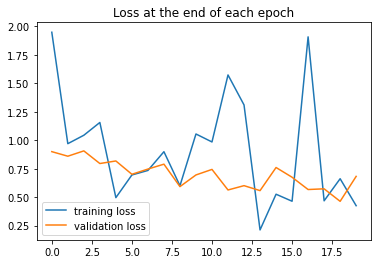

In [ ]:
plot_loss(train_losses,test_losses)

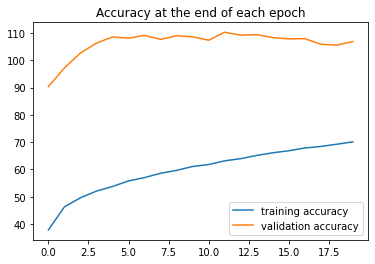

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/18000:.3f}%') # print the most recent result as a percent

[tensor(9034), tensor(9719), tensor(10266), tensor(10630), tensor(10854), tensor(10810), tensor(10910), tensor(10767), tensor(10899), tensor(10860), tensor(10735), tensor(11027), tensor(10920), tensor(10941), tensor(10831), tensor(10783), tensor(10792), tensor(10588), tensor(10555), tensor(10687)]

Test accuracy: 59.372%


Test accuracy: 10876/18000 =  60.422%


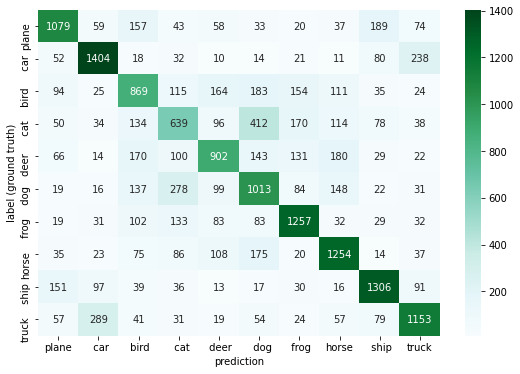

In [ ]:
confusionMatrix(test_data,modelb)

## PartC)

In [ ]:
class CNNc(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0)
        self.batch_norm1=nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=10, kernel_size=3, padding=0)
        self.batch_norm2=nn.BatchNorm2d(10)
        self.fc1 = nn.Linear(10* 13 * 13, 10)     

    def forward(self, X):
        X = F.relu(self.batch_norm1(self.conv1(X)))
        X = F.relu(self.batch_norm2(self.conv2(X)))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(X.size(0), -1)
        X = self.fc1(X)
        
        return F.log_softmax(X, dim=1)


In [ ]:
torch.manual_seed(101)
modelc = CNNc()
modelc

CNNc(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1690, out_features=10, bias=True)
)

In [ ]:
count_parameters(modelc)

  2400
    32
    32
    32
  2880
    10
    10
    10
 16900
    10
______
 22316


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelc.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_losses,test_losses,train_correct,test_correct=train_model(train_loader,test_loader,modelc)

epoch:  0  batch: 1000 [ 10000/42000]  loss: 1.13184845    accuracy:  37.570%
epoch:  0  batch: 2000 [ 20000/42000]  loss: 1.64816701    accuracy:  42.160%
epoch:  0  batch: 3000 [ 30000/42000]  loss: 2.01769185    accuracy:  44.837%
epoch:  0  batch: 4000 [ 40000/42000]  loss: 1.56032646    accuracy:  46.760%
epoch:  1  batch: 1000 [ 10000/42000]  loss: 1.88931298    accuracy:  56.700%
epoch:  1  batch: 2000 [ 20000/42000]  loss: 1.37427223    accuracy:  56.980%
epoch:  1  batch: 3000 [ 30000/42000]  loss: 1.70950699    accuracy:  57.310%
epoch:  1  batch: 4000 [ 40000/42000]  loss: 1.24955249    accuracy:  57.565%
epoch:  2  batch: 1000 [ 10000/42000]  loss: 0.73813552    accuracy:  61.660%
epoch:  2  batch: 2000 [ 20000/42000]  loss: 1.32885885    accuracy:  61.160%
epoch:  2  batch: 3000 [ 30000/42000]  loss: 1.62010884    accuracy:  61.143%
epoch:  2  batch: 4000 [ 40000/42000]  loss: 1.00972486    accuracy:  61.025%
epoch:  3  batch: 1000 [ 10000/42000]  loss: 0.85204381    accur

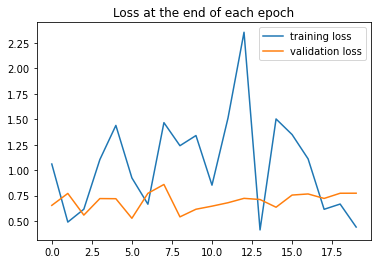

In [ ]:
plot_loss(train_losses,test_losses)

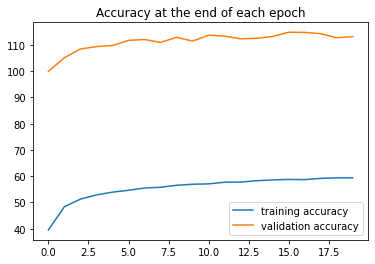

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/18000:.3f}%') # print the most recent result as a percent

[tensor(9992), tensor(10513), tensor(10845), tensor(10933), tensor(10976), tensor(11172), tensor(11205), tensor(11095), tensor(11287), tensor(11145), tensor(11369), tensor(11334), tensor(11232), tensor(11251), tensor(11321), tensor(11481), tensor(11476), tensor(11425), tensor(11272), tensor(11317)]

Test accuracy: 62.872%


Test accuracy: 11576/18000 =  64.311%


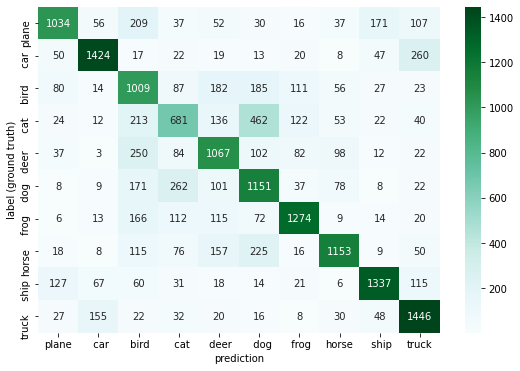

In [ ]:
confusionMatrix(test_data,modelc)

## Part d)

In [ ]:
class CNNd(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, padding=0)
        self.batch_norm1=nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=16, kernel_size=5, padding=0)
        #self.batch_norm2=nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=5, padding=0)
        #self.batch_norm3=nn.BatchNorm2d(10)
        self.fc1 = nn.Linear(10* 10 * 10, 128) 
        self.fc2 = nn.Linear(128, 10)   

    def forward(self, X):
        X = F.relu(self.batch_norm1(self.conv1(X)))
        X = F.relu(self.conv2(X))
        X = F.dropout(X, p=0.4, training=True, inplace=False)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(X.size(0), -1)
        
        X = F.relu(self.fc1(X))
        X = F.dropout(X, p=0.2, training=True, inplace=False)
        X = self.fc2(X)
     
        return F.log_softmax(X, dim=1)
        

In [ ]:
torch.manual_seed(101)
modeld = CNNd()
modeld

CNNd(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (batch_norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
count_parameters(modeld)

   750
    10
    10
    10
  4000
    16
  4000
    10
128000
   128
  1280
    10
______
138224


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modeld.parameters(), lr=0.01,momentum=0.6)

In [ ]:
train_losses,test_losses,train_correct,test_correct=train_model(train_loader,test_loader,modeld)

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.71231008    accuracy:  27.280%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.63361549    accuracy:  32.440%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.97020209    accuracy:  35.307%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.56626773    accuracy:  37.383%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.76162875    accuracy:  39.012%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 0.85476333    accuracy:  47.190%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.06680214    accuracy:  47.770%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.33578134    accuracy:  48.723%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.40139151    accuracy:  49.260%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.77796435    accuracy:  49.798%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 0.79760730    accuracy:  54.050%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.35821629    accuracy:  54.010%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 0.96096164    accur

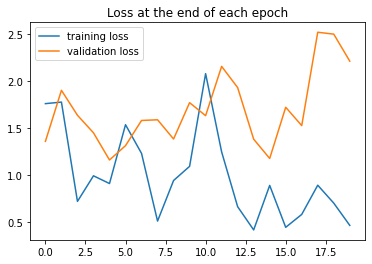

In [ ]:
plot_loss(train_losses,test_losses)

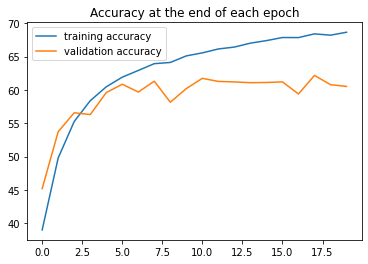

In [ ]:
plot_accuracy(train_correct,test_correct)

Test accuracy: 6107/10000 =  61.070%


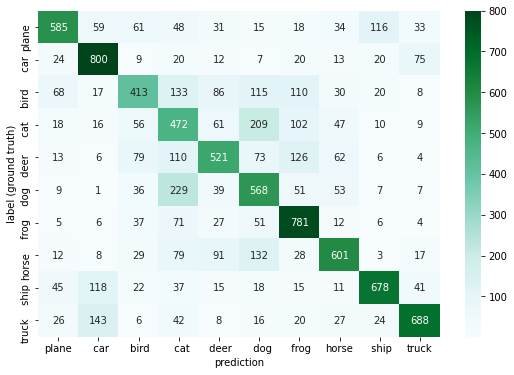

In [ ]:
confusionMatrix(test_data,modeld)

In [ ]:
from torchsummary import summary

In [ ]:
torch.save(modeld.state_dict(), 'CIFAR10-BestCNN-Model.pt')

In [ ]:
summary(modeld, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             760
       BatchNorm2d-2           [-1, 10, 28, 28]              20
            Conv2d-3           [-1, 16, 24, 24]           4,016
            Conv2d-4           [-1, 10, 20, 20]           4,010
            Linear-5                  [-1, 128]         128,128
            Linear-6                   [-1, 10]           1,290
Total params: 138,224
Trainable params: 138,224
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.22
Params size (MB): 0.53
Estimated Total Size (MB): 0.76
----------------------------------------------------------------
